# Meteorološki podatki 

Najprej potrebujemo pridobiti meteorološke podatke na lokaciji stavbe.
Le ta stoji v Ljubljani, zato so GK koordinate sledeče: Y = 462645 m, X = 102486 m, pridobljeni podatki pa sledeči:

 - projektna temperatura okolice  $\theta_{e, ref}$: **-13°C**
 - povprečna letna temperatura okolice $\theta_{e, ann}$: **9.9°C**
 - povprečna mesečna dnevna energija sončnega obsevanja $G_{sol,i,d}$: **1121 kWh/m$^{2}$**
 - povprečna dnevna temperatura okolice $\theta_{e, d}$: Izračunana v naslednjih korakih.

In [1]:
thetaeref = -13 #°C
thetaeann = 9.9 #°C
gsolid = 1121 #kWh/m2

Uvozimo potrebne module

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Uvozimo podatke za tipično leto.
Podatki so v CSV datoteki s sledečimi vrsticami:

'Mesec', 'Dan', 'Ura', 'Temperatura', 'RelativnaVlaznost', 'GlobalnoSevanje', 'HitrostVetra', 'SmerVetra'

Uporabimo le prve štiri, 

In [3]:
import zModel

In [4]:
razredi = list(map(lambda x: ( x, x+1 ) , list(range(-20,20,2))))
razredi

[(-20, -19),
 (-18, -17),
 (-16, -15),
 (-14, -13),
 (-12, -11),
 (-10, -9),
 (-8, -7),
 (-6, -5),
 (-4, -3),
 (-2, -1),
 (0, 1),
 (2, 3),
 (4, 5),
 (6, 7),
 (8, 9),
 (10, 11),
 (12, 13),
 (14, 15),
 (16, 17),
 (18, 19)]

Prikažemo lahko količine temperatur po razredih.

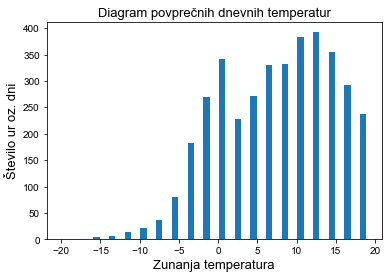

In [5]:
def displayTemperatureByTime():
    # Get the data
    data = zModel.temperaturesByTime(razredi,'meteorological_year_letalisce-jp-ljubljana-1.csv',method='hourly')
    x = list(map(lambda x: x[0], data))
    y = list(map(lambda x: x[1], data))
    # Create bars
    plt.bar(x, y)
    # Add axis titles
    plt.xlabel('Zunanja temperatura', fontsize='13', horizontalalignment='center')
    plt.ylabel('Število ur oz. dni', fontsize='13', horizontalalignment='center')
    plt.title('Diagram povprečnih dnevnih temperatur', fontsize='13')
    # Add design
    plt.style.use('seaborn-white')
    # Show graphic
    plt.show()
displayTemperatureByTime()

# Notranja projektna temperatura

Določiti moramo notranjo projektno temperaturo. Za stanovanje je $\theta_{i, ref}$: **20°C**
XXX

In [6]:
thetairef = 20 #°C

# Izračun potrebne toplotne moči toplotne črpalke

Sedaj, ko smo določili vse robne temperaturne pogoje, lahko začnemo z izračunom toplotnih moči. Če želimo določiti moč toplotne črpalke $\dot{Q}_{hp}$ moramo najprej določiti še toplotno moč potrebno za ogrevanje stavbe $\dot{Q}_{h}$, toplotno moč za pripravo STV $\dot{Q}_{stv}$ in moč drugih odjemov $\dot{Q}_{dod}$

Skupno moč tako določimo s sledečo enačbo, v kateri nastopi še korekcijski faktor akumulacije toplote:

$$\dot{Q}_{hp} =  \dot{Q}_{hp} * f_{h} + \dot{Q}_{stv} + \dot{Q}_{dod}$$

Preden določimo toplotno moč, moramo določiti vse člene zgornje enačbe.

## Korekcijski faktor
Izbran je korekcijski faktor $f_{h} = 0.93$ za opečnato stanovanjsko hišo iz 1970.



In [7]:
fh = 0.93

## Toplotna moč za ogrevanje stavbe
Toplotno moč za ogrevanje stavbe $\dot{Q}_{h}$ se izračuna kot seštevek transmisijskih, ventilacijskih in dodatnih toplotnih izgub:

$$\dot{Q}_{h} = \dot{Q}_{t} + \dot{Q}_{v}+ \dot{Q}_{h,dod}$$


### Transmisijske toplotne izgube in ventilacijske izgube
Transmisijske toplotne izgube so bile določene s pomočjo programa Gradbena fizika URSA 4, v okviru predmeta Raba Energije. V naslednji sliki so prikazani izračunani koeficijenti transmisijskih in ventilacijskih toplotnih izgub $H_{t}$ in $H_{v}$.

<img src="ursa_izracun.png">

Določimo lahko torej:

$$ H_{t} = 257.6 W/K $$
$$ H_{v} = 107.7 W/K $$
$$ H = 365.3 W/K $$

In [8]:
h = 365.3/1000 #kW/K

Za določitev moči uporabimo enačbo:

$$\dot{Q}_{h} = H*(\theta_{i,ref} - \theta_{e,ref})$$

In [9]:
dQh = h * (thetairef - thetaeref)
print(f'Toplotna moč za ogrevanje stavbe je: {round(dQh)}kW')

Toplotna moč za ogrevanje stavbe je: 12kW


## Toplotna moč za pripravo sanitarne tople vode
### Dnevna potrebna energija
Sedaj moramo določiti še toplotno moč potrebno za pripravo STV. Predpostavimo da uporabljamo zalogovnik STV. V enačbi za določitev dnevne energije STV $Q_{stv}$ upoštevamo število uporabnikov $N$, poprečno uporabo STV na osebo $q$ in temperaturno razliko med zahtevano temperaturo STV $\theta_{dp,ref}$ in temperaturo sveže dobavljene vode $\theta_{cw}$:

$$ Q_{stv} = 0.00116 *N*q*(\theta_{dp,ref}-\theta_{cw})$$

Ker se pri izračunu gre za stanovansjko poslopje je izbran $q = 60 L/ (oseba*dan)$

In [10]:
q = 25 # L/oseba*dan

Izbrati moramo še željeno temperaturo STV $\theta_{dp,ref}$, standardna je $60°C$, zato bomo to izbrali tudi mi, ter temperaturo hladne vode v omrežju $\theta_{cw}$, ki je izbrana na $12°C$

V poslopju sta dve gospodinjstvi, skupno pa trenutno v poslopju stanuje 5 oseb. Torej: $N=5$.

In [11]:
thetacw = 12 #°C
thetadpref = 60 #°C
N = 5 #število oseb

Sedaj lahko izračunamo dnevno energijo za STV.

In [12]:
Qstv = 0.00116 * N * q * (thetadpref-thetacw)
print(f'Dnevna energija potrebna za ogrevanje STV je: {round(Qstv,0)}kWh')

Dnevna energija potrebna za ogrevanje STV je: 7.0kWh


Iz energije lahko moč določimo s sledečo enačbo:
$$\dot{Q}_{stv} = \frac{Q_{stv}}{t_{stv}}*f_{stv}$$

Za $f_{stv}$ uporabimo vrednost 1.21
Čas ogrevanja STV pa izberemo da je 4 ure. $t_{stv}=4ure$

In [13]:
fstv = 1.21
tstv = 2 #ure
dQstv = Qstv/tstv*fstv
print(f'Potrebna moč za zagotavljanje nemotene oskrbe STV je {round(dQstv,0)} kW')

Potrebna moč za zagotavljanje nemotene oskrbe STV je 4.0 kW


### Velikost hranilnika STV
Najprej moramo določiti volumen vode, ki zadošča pokrivanju dnevne porabe STV, nato pa je potrebno upoštevati še dnevne toplotne izgube hranilnika STV.

Enačba ki popisuje potrebno velikost volumna vode je sledeča. V njej nastopa, poleg do sedaj že definiranih spremenljivk še dnevne toplotne izgube hranilnika $Q_{1,s}$ in učinkovitost volumna hranilnika, ki v povprečju znaša $\eta_{s} = 0.8$.

Sicer je $Q_{1,s}$ odvisen od velikosti volumna vendar, ker bomo zalogovnik izbrali iz kataloga, in ker drugi člen predstavlja veliko manjši del kot prvi, se lahko izračunu z diferencialno enačbo izognemo, ter minimalni volumen določimo le s prvim členom, drugega pa nato upoštevamo pri določitvi minimalnega volumna. 
$$V_{dp,ref}=\frac{860*(\dot{Q}_{stv}*t_{stv})}{(\theta_{dp,ref}-\theta_{cw})*\eta_{s}}+\frac{Q_{1,s}}{0.00116*(\theta_{dp,ref}-\theta_{cw})}$$

In [14]:
etas = 0.8
Vdpref1 = (860*dQstv*tstv)/((thetadpref-thetacw)*etas)
print(f'Preliminarni volumen hranilnika znaša {round(Vdpref1,0)}L')

Preliminarni volumen hranilnika znaša 189.0L


Sedaj lahko iz preliminarnega volumna določimo še toplotne izgube in jih upoštevamo v celotnem izračunu.

<img src="izgubevstv.png">

Pri preliminarnem volumnu 450L znaša dnevna izgubljena energija približno 3.2 kWh

In [15]:
Q1s = 1.5 #kWh/dan
Vdpref2 = Vdpref1 + Q1s/(0.00116 * (thetadpref-thetacw))
print(f'Volumen hranilnika znaša {round(Vdpref2,0)}L')

Volumen hranilnika znaša 216.0L


### Izbor hranilnika iz kataloga
V KRONOTERM katalogu je za izbrano ADAPT 0416 enoto na voljo 200 litrski hranilnik. Pri gospodarni rabi STV bo le-ta zadostoval. $V_{s}=200L$.

<img src="notranjaenota.png">

In [16]:
Vs = 200 #L

Na podlagi izbranega volumna lahko določimo dejansko potrebno moč toplotne črpalke po naslednji enačbi:

$$\dot{Q}_{stv,0set}=\frac{V_{s}*0.00116*(\theta_{set}-\theta_{cw})}{t_{stw}}$$

In [17]:
dQstv0set = (Vs*0.00116*(thetadpref-thetacw))/tstv
print(f'Prava moč toplotne črpalke za dobavljanje STV znaša {round(dQstv0set,0)}kW')

Prava moč toplotne črpalke za dobavljanje STV znaša 6.0kW


## Skupna toplotna moč
Sedaj lahko izračunamo še skupno toplotno moč, katero mora dosegati toplotna črpalka.

-E---ENAČBA



In [18]:
dQhp = dQh * fh + dQstv0set
print(f'Skupna toplotna moč znaša {round(dQhp,0)}kW')

Skupna toplotna moč znaša 17.0kW


# Raba energije za delovanje toplotne črpalke

## Toplotna energija za ogrevanje in pripravo STV
### Toplotna energija za ogrevanje stavbe

Potrebno toplotno energijo bomo določili po naslednji enačbi.
Ker je površina južno obrnjenih oken majhna in ker je osenčenost v ogrevalni sezoni velika, se dobitke zaradi sončnega sevanja $Q_{sol,d}$ zanemari.

Uporabimo enačbo:
$$Q_{h,d}=\dot{Q}_{h}*\frac{\theta_{i,ref}-\theta_{e,d}}{\theta_{i,ref}-\theta_{e,ref}}*24-Q_{hg,d}$$

Notranje toplotne dobitke $Q_{hg,d}$, ki predstavljajo oddajo naprav in ljudi pa določimo po povprečni vrednosti $4 W/m^{2}$

In [19]:
dQhgd = 4*181/1000
print(f'Skupni notranji toplotni dobitki znašajo {round(dQhgd,0)}kW')

Skupni notranji toplotni dobitki znašajo 1.0kW


Sedaj lahko določimo povprečne zunanje temperature na podlagi prej nastavljenih razredov. [°C]

In [20]:
thetaed = zModel.temperaturesByTime(razredi, returnShape='temperature')
thetaed = np.array(thetaed)
thetaed

array([-19.5, -17.5, -15.5, -13.5, -11.5,  -9.5,  -7.5,  -5.5,  -3.5,
        -1.5,   0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,
        16.5,  18.5])

S pomočjo teh temperatur lahko določimo toplotne izgube v posameznih razredih. [kWh/dan]

In [21]:
Qhd = dQh*(thetairef-thetaed)/(thetairef-thetaeref)*24-dQhgd*24
Qhd

array([328.9284, 311.394 , 293.8596, 276.3252, 258.7908, 241.2564,
       223.722 , 206.1876, 188.6532, 171.1188, 153.5844, 136.05  ,
       118.5156, 100.9812,  83.4468,  65.9124,  48.378 ,  30.8436,
        13.3092,  -4.2252])

Če sedaj te izgube pomnožimo s številom dni (oziroma ur, odvisno od metode) določimo potrebno toplotno energijo za vsak razred posebej. [kWh]

In [22]:
thetaedtime = np.array(zModel.temperaturesByTime(razredi,'meteorological_year_letalisce-jp-ljubljana-1.csv',returnShape='time'))
Qhd*thetaedtime

array([   0.    ,    0.    ,    0.    ,    0.    ,    0.    ,  482.5128,
        223.722 ,  412.3752, 1131.9192, 1026.7128, 1996.5972, 1632.6   ,
       1185.156 , 1413.7368, 1335.1488,  725.0364,  774.048 ,  400.9668,
        266.184 ,  -76.0536])

#### Celoletna toplotna energija
Nazadnje še seštejemo toplotne energije, da dobimo celoletno toplotno energijo za ogrevanje stavbe. [kWh]

In [23]:
np.sum(Qhd*thetaedtime)

12930.662400000001

### Toplotna energija za pripravo STV
Potrebno toplotno energijo za pripravo STV se določi na osnovi že določene toplotne moči, z naslednjo enačbo:
$$Q_{stv,d}=\dot{Q}_{stv,0set}*t_{stv}$$

In [24]:
Qstvd=dQstv0set*tstv
print(f'Skupna dnevna raba energije za pripravo STV znaša {round(Qstvd,0)}kWh/dan')

Skupna dnevna raba energije za pripravo STV znaša 11.0kWh/dan


## Temperatura izstopajoče ogrevane vode

XXX Manjka

## Čas delovanja toplotne črpalke


Toplotna moč črpalke. Toplotno moč lahko določimo s pomočjo sledečega diagrama, katerega nam poda proizvajalec.

<img src="grelnamoč.png">

Vidimo lahko, da je padec grelne moči sorazmerno linearen. Izberemo visokotemperaturni režim 55°C. Lahko torej določimo dve točki, ter med njima potegnemo premico:
$T_{1}=(-25,7)$, $T_{2}=(-5,12)$

Določimo funkcijo moči:

In [25]:
from scipy import interpolate
x=np.array([-25,-5,45])
y=np.array([7,12,12])
fdQhp0 = interpolate.interp1d(x, y, kind='linear')

### Bivalentna točka
Želimo izrisati graf obratovanja toplotne črpalke. Primer grafa iz predloge.
Ločimo dva načina obratovanja toplotne črpalke: monovalentno in bivalentno obratovanje. Pri monovalentnem obratovanju toplotna črpalka pokriva celotne potrebe po toplotni moči - slika levo.

Pri bivalentnem obratovanju pa toplotna črpalka pokriva del toplotne moči, preostali del pa pokriva drugi toplotni vir - slika desno. V primeru bivalentnega obratovanje toplotne črpalke, je pri izbiri toplotne moči toplotne črpalke pomembno določitev bivalentne točke. Ta predstavlja zunanjo temperaturo do katere TČ pokriva potrebe po toploti v stavbi .

<img src="bivalentnatocka.png">


Določimo tudi funkcijo potrebne moči za ogrevanje stavbe

In [26]:
fdQh = interpolate.interp1d(thetaed, dQh*(thetairef-thetaed)/(thetairef-thetaeref), kind='linear')

Izrišemo graf naše funkcije moči in potrebne moči za ogrevanje hiše. Na presečišču se nahaja bivalentna točka. 


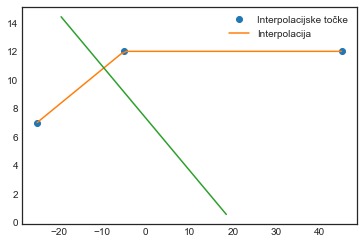

In [27]:
x_g = np.linspace(x[0], x[-1], 20*len(x)-1)
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(x_g, fdQhp0(x_g), '-', label='Interpolacija')
plt.plot(thetaed,fdQh(thetaed))
plt.legend();

Kot lahko opazimo je bivalentna točka nekje pri $-5°C$. Temperature, ki so nižje od tega zahtevajo alternativni način ogravanja, kot je opisano v začetku poglavja.

## Čas delovanja toplotne črpalke
### Teoretični čas obratovanja

Preverimo lahko še koliko ur bi morala TČ obratovati, da zadosti dnevne potrebe po toploti. Vse vrednosti nad 24 ur pomenijo, da potrebujemo alternativni vir.

Uporabimo enačbo:
$$t_{ON,hp,d}=\frac{Q_{h,d}}{\dot{Q}_{hp,h,d}}+\frac{Q_{stv,d}}{\dot{Q}_{hp,stv,d}}[h]$$

Ker ogrevanje in STV grejemo z enako črpalko uporabimo pri obeh enako moč.

In [28]:
tonhpd = Qhd / fdQhp0(thetaed) + Qstvd / fdQhp0(thetaed)
tonhpd #h/dan

array([40.60470448, 36.34140845, 32.532864  , 29.10999494, 26.01704096,
       23.20849655, 20.64685714, 18.30093474, 16.6491    , 15.1879    ,
       13.7267    , 12.2655    , 10.8043    ,  9.3431    ,  7.8819    ,
        6.4207    ,  4.9595    ,  3.4983    ,  2.0371    ,  0.5759    ])

### Čas obratovanja dogrevanja
Ker naša toplotna črpalka ne zadostuje zahtevani moči, moramo moč dodajati z dodatnim grelcem. Ta je izveden kot navadni električni grelec ki vso svojo moč pretvori v toploto. Predvideti želimo koliko časa bo moral grelec delovati.
To storimo s sledečo enačbo:
$$t_{ON,pu,d}=\frac{Q_{h,d}+Q_{stv,d}+Q_{dod,d}-(Q_{h,hp,d}+Q_{stv,hp,d}+Q_{dod,hp,d})}{\dot{Q}_{pu}}$$

Ker ogrevanje in STV grejemo iz istega vira (TČ) bomo upoštevali celotno energijo, ki jo TČ lahko dobavi v enem dnevu. Prav tako ni dodatnih ponorov toplote, zato teh členov ne upoštevamo. Dobimo sledečo enačbo:
$$t_{ON,pu,d}=\frac{Q_{h,d}+Q_{stv,d}-Q_{hp,d}}{\dot{Q}_{pu}} [h]$$

Za vsak temperaturni razred preverimo koliko časa mora delovati pomožni grelec. Negativne vrednosti pomenijo da toplotna črpalka zagotavlja presežek energije. Enote so v urah.

V poglavju **Izbor hranilnika iz kataloga** lahko vidimo, da ima izbrana *TČ ADAPT 0416 K3 HT / HK 1F*  $2*2kW$ grelec.

In [29]:
dQpu = 4 #kW

In [38]:
tonpud = (Qhd + Qstvd - fdQhp0(thetaed) * 24) / dQpu
tonpud #h/dan

array([ 34.7661,  27.3825,  19.9989,  12.6153,   5.2317,  -2.1519,
        -9.5355, -16.9191, -22.0527, -26.4363, -30.8199, -35.2035,
       -39.5871, -43.9707, -48.3543, -52.7379, -57.1215, -61.5051,
       -65.8887, -70.2723])

Konkretno za naše klimatske pogoje je v vsakem temperaturnem režimu toliko ur obratovanja:

In [40]:
ar = tonpud * thetaedtime
ar #h

array([    0.    ,     0.    ,     0.    ,     0.    ,     0.    ,
          -4.3038,    -9.5355,   -33.8382,  -132.3162,  -158.6178,
        -400.6587,  -422.442 ,  -395.871 ,  -615.5898,  -773.6688,
        -580.1169,  -913.944 ,  -799.5663, -1317.774 , -1264.9014])

Zanima nas še skupno število obratovalnih ur dogrevanja. Za vsak temperaturni razred moramo torej pomnožiti z številom dni v razredu. Negativne vrednosti pomenijo da toplotna črpalka zagotavlja presežek energije in da ne potrebujemo dogrevanja.

In [41]:
tonpu = ar[ar>0].sum()
print(f'Skupno število ur obratovanja dogrevanja {round(tonpu,0)} ur')

Skupno število ur obratovanja dogrevanja 0.0 ur


## Raba električne energije za delovanje toplotne črpalke
Rabo električne energije za delovanje toplotne črpalke določimo na osnovi obratovalnih karakteristik toplotne črpalke in njenega časa obratovanja.

Določili bomo porabo na osnovi rabe toplotne energije in učinkovitosti toplotne črpalke, s sledečo enačbo:

$$E_{hp,d}=\frac{Q_{h,d}}{COP_{h,s}}+\frac{Q_{stv,d}}{COP_{stv,s}}$$

Originalna enačba kliče po uporabi dnevne COP vrednosti, vendar le-te proizvajalec v katalogu ne podaja. Prav tako proizvajalec ne podaja COP v odvisnosti od zunanje temperature, zato bomo uporabili sezonski COP, ki je za toplotni režim 55°C: $COP_{s}=3.75$

<img src="cop.png">

In [34]:
COPs=3.75

V vseh toplotnih režimih je poraba energije sledeča:

In [35]:
Ehpd = Qhd / COPs + Qstvd / COPs
Ehpd #kWh/dan

array([90.68384, 86.008  , 81.33216, 76.65632, 71.98048, 67.30464,
       62.6288 , 57.95296, 53.27712, 48.60128, 43.92544, 39.2496 ,
       34.57376, 29.89792, 25.22208, 20.54624, 15.8704 , 11.19456,
        6.51872,  1.84288])

Za naše pogoje je raba električne energije sledeča:


In [36]:
Ehpd * thetaedtime

array([  0.     ,   0.     ,   0.     ,   0.     ,   0.     , 134.60928,
        62.6288 , 115.90592, 319.66272, 291.60768, 571.03072, 470.9952 ,
       345.7376 , 418.57088, 403.55328, 226.00864, 253.9264 , 145.52928,
       130.3744 ,  33.17184])

Skupna sezonska poraba TČ pa:
    

In [37]:
Ehp = (Ehpd * thetaedtime).sum() #kWh

3923.31264

# Sezonski faktor učinkovitosti
Sezonski faktor učinkovitosti oz. SPF ovrednotimo z razmerjem med proizvedeno toploto in vloženo energijo. Za primer električno gnane toplotne črpalke z dodatnim električnih grelcem se sezonski faktor učinkovitosti sistema SPF določi po sledeči enačbi:

$$SPF=\frac{Q_{h}+Q_{stv}+Q_{dod}}{E_{hp}+E_{bu}+E_{aux}}$$

V katalogu lahko razberemo, da je moč obtočne črtpalke $75W$. Dolžina ogrevalne sezone je **140 dni**

In [ ]:
Paux = 75/1000 #kW

In [44]:
SPF = ((Qhd*thetaedtime).sum() + Qstvd*365 ) / ( Ehp + )
SPF

16995.3024